<a href="https://colab.research.google.com/github/Shifoue/Segmentation/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Shifoue/Portfolio.git

Cloning into 'Portfolio'...
remote: Enumerating objects: 4210, done.
remote: Counting objects: 100% (531/531), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 4210 (delta 245), reused 506 (delta 225), pack-reused 3679
Receiving objects: 100% (4210/4210), 47.77 MiB | 34.72 MiB/s, done.
Resolving deltas: 100% (811/811), done.


In [2]:
!cd Portfolio/Eye_Segmentation_Project/

In [3]:
!pip install utils
!pip install torchmetrics

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=4545c896d1ca5753299f6780a39544070be97e8c1b45b0b2e7def6de46b04019
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.wh

In [4]:
!unzip Dataset_Faces_training.zip
!unzip Dataset_Faces_validation.zip

!unzip Dataset_Faces_Mask_training.zip
!unzip Dataset_Faces_Mask_validation.zip

unzip:  cannot find or open Dataset_Faces_training.zip, Dataset_Faces_training.zip.zip or Dataset_Faces_training.zip.ZIP.
unzip:  cannot find or open Dataset_Faces_validation.zip, Dataset_Faces_validation.zip.zip or Dataset_Faces_validation.zip.ZIP.
unzip:  cannot find or open Dataset_Faces_Mask_training.zip, Dataset_Faces_Mask_training.zip.zip or Dataset_Faces_Mask_training.zip.ZIP.
unzip:  cannot find or open Dataset_Faces_Mask_validation.zip, Dataset_Faces_Mask_validation.zip.zip or Dataset_Faces_Mask_validation.zip.ZIP.


In [5]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.depht = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, X):
        return self.depht(X)

class myUNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
      super(myUNET, self).__init__()
      self.encode = nn.ModuleList()
      self.decode = nn.ModuleList()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #divide size per 2

      # Encode
      for feature in features:
          self.encode.append(DoubleConv(in_channels, feature))
          in_channels = feature

      # Decode
      for feature in reversed(features):
          self.decode.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
          self.decode.append(DoubleConv(feature*2, feature))

      self.bottleneck = DoubleConv(features[-1], features[-1]*2)
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, X):
        skip_connections = []

        for depht in self.encode:
            X = depht(X)
            skip_connections.append(X)
            X = self.pool(X)

        X = self.bottleneck(X)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.decode), 2):
            X = self.decode[i](X)
            #skip_connection = skip_connections[-1 - i//2]
            skip_connection = skip_connections[i//2]

            if X.shape != skip_connection.shape:
                X = torch.nn.functional.interpolate(X, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, X), dim=1)
            X = self.decode[i+1](concat_skip)

        return self.final_conv(X)

def test():
    x = torch.randn((3, 1, 160, 160))
    m = myUNET(in_channels=1, out_channels=1)
    pred = m(x)

    assert pred.shape == x.shape

test()

In [6]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [7]:
class FaceDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") #, dtype=np.float32)

        #mask[mask == 255.0] = 1.0
        #mask = mask/255.0

        if self.transform is not None:

            #augmentations = self.transform(image=image, mask=mask)
            image = self.transform(image) #augmentations["image"]
            mask = self.transform(mask) #augmentations["mask"]
            mask = (mask > 0.5).float()

        return image, mask

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [9]:
#Hyperparamters

LEARNING_RATE = 1e-4 #1e-2 for SGD 1e-4 ADAM
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 218
IMAGE_WIDTH = 178
PIN_MEMORY = True
LOAD_MODEL = True
IMG_DIR_TRAIN = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_training"
IMG_DIR_VAL = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_validation"
MASK_DIR_TRAIN = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_Mask_training"
MASK_DIR_VAL = "/content/Portfolio/Eye_Segmentation_Project/Dataset_Faces_Mask_validation"
SAVE_DIR = "Saved_Images"

In [10]:
import cv2

In [11]:
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
    train_data = FaceDataset(image_dir=train_dir, mask_dir=train_mask_dir, transform = train_transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    val_data = FaceDataset(image_dir=val_dir, mask_dir=val_mask_dir, transform = val_transform)
    val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0 #did i predict correctly
    num_pixels = 0 #how many pixel are correct Area accuracy

    #In order to force the algorithm on finding a good solution instead of only putting black pixel to get a good accuracy due to the small size of the target
    dice_score = 0

    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8) #calculate the intersection between ground truth and prediction

    print(f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100}:.2f")
    print(f"Dice score {dice_score/len(loader)}")

    model.train()

    return dice_score/len(loader), num_correct/num_pixels

def save_predictions_as_imgs(loader, model, folder = SAVE_DIR, device="cuda"):
    if not os.path.exists(folder):
      os.mkdir(folder)

    model.eval()

    for i , (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            #print(y.shape)
            #print(preds.shape)
            #y = (y > 0.5).float()

            # preds_path = os.path.join(folder, f"pred_{i}.jpg")
            # truth_path = os.path.join(folder, f"truth_{i}.jpg")
            # print(preds_path)
            # print(truth_path)


            #cv2.imwrite(preds_path, preds.cpu().detach().numpy())
            #cv2.imwrite(truth_path, y.cpu().detach().numpy())
            torchvision.utils.save_image(preds, f"{folder}/pred_{i}.jpg")
            torchvision.utils.save_image(y, f"{folder}/truth_{i}.jpg")

In [12]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for i_batch, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.cuda.amp.autocast():
            preds = model(data)
            loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

In [13]:
import torch.nn.functional as F

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1. - dice

In [15]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        #A.Rotate(limit=35, p=1.0),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.1),
        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        #transforms.Grayscale(),
    ]
)

validation_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    ]
)

UNET = myUNET(in_channels=3, out_channels=1).to(DEVICE) #for multiple classes change out channels to number of classes
#loss_fn = nn.BCEWithLogitsLoss() # for multiple classes use cross entropy

loss_fn = DiceLoss() #Needed to force the NN to chose another strategy than putting every pixel to white

#optimizer = optim.Adam(UNET.parameters(), lr=LEARNING_RATE)
optimizer = optim.AdamW(UNET.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD(UNET.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = optim.SGD(UNET.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

train_loader, val_loader = get_loaders(
    IMG_DIR_TRAIN,
    MASK_DIR_TRAIN,
    IMG_DIR_VAL,
    MASK_DIR_VAL,
    BATCH_SIZE,
    train_transform,
    validation_transform,
    NUM_WORKERS,
    PIN_MEMORY
)

scaler = torch.cuda.amp.GradScaler()

old_dice = 0

dice_score_list = []
accuracies = []

for epoch in range(NUM_EPOCHS):
    #print(train_loader)
    train(train_loader, UNET, optimizer, loss_fn, scaler)

    checkpoint =  {
        "state_dict": UNET.state_dict(),
        "optimizer": optimizer.state_dict()
    }

    dice_score, accuracy = check_accuracy(val_loader, UNET, device=DEVICE)
    dice_score_list.append(dice_score.cpu())
    accuracies.append(accuracy.cpu())

    if old_dice < dice_score :
      save_checkpoint(checkpoint)
      old_dice = dice_score

      save_predictions_as_imgs(val_loader, UNET, folder="/content/Saved_Images", device=DEVICE)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 50/50 [00:14<00:00,  3.45it/s, loss=0.975]


Got 7531973/7760800 with accuracy 97.05149841308594:.2f
Dice score 0.15764504671096802
=> Saving checkpoint


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.353]


Got 7748285/7760800 with accuracy 99.83873748779297:.2f
Dice score 0.7108160257339478
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.51it/s, loss=0.213]


Got 7750417/7760800 with accuracy 99.86620330810547:.2f
Dice score 0.7587864995002747
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.44it/s, loss=0.208]


Got 7751565/7760800 with accuracy 99.88099670410156:.2f
Dice score 0.7920501828193665
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.39it/s, loss=0.193]


Got 7751506/7760800 with accuracy 99.88024139404297:.2f
Dice score 0.798152506351471
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.34it/s, loss=0.119]


Got 7752743/7760800 with accuracy 99.89617919921875:.2f
Dice score 0.8130412697792053
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  3.95it/s, loss=0.183]


Got 7752897/7760800 with accuracy 99.89816284179688:.2f
Dice score 0.8152444362640381
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.17it/s, loss=0.201]


Got 7752555/7760800 with accuracy 99.89375305175781:.2f
Dice score 0.8233104944229126
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.08it/s, loss=0.212]


Got 7752757/7760800 with accuracy 99.8963623046875:.2f
Dice score 0.8230421543121338


100%|██████████| 50/50 [00:13<00:00,  3.74it/s, loss=0.978]


Got 7451090/7760800 with accuracy 96.0093002319336:.2f
Dice score 0.12652112543582916


100%|██████████| 50/50 [00:13<00:00,  3.84it/s, loss=0.971]


Got 7675739/7760800 with accuracy 98.90396118164062:.2f
Dice score 0.34362688660621643


100%|██████████| 50/50 [00:12<00:00,  3.86it/s, loss=0.967]


Got 7711280/7760800 with accuracy 99.3619155883789:.2f
Dice score 0.4704417586326599


100%|██████████| 50/50 [00:13<00:00,  3.84it/s, loss=0.954]


Got 7722860/7760800 with accuracy 99.5111312866211:.2f
Dice score 0.5361562967300415


100%|██████████| 50/50 [00:13<00:00,  3.82it/s, loss=0.946]


Got 7730335/7760800 with accuracy 99.6074447631836:.2f
Dice score 0.5902539491653442


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.934]


Got 7735647/7760800 with accuracy 99.67589569091797:.2f
Dice score 0.6331098675727844


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.909]


Got 7742314/7760800 with accuracy 99.76179504394531:.2f
Dice score 0.7007547616958618


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.87]


Got 7741337/7760800 with accuracy 99.74920654296875:.2f
Dice score 0.6899428963661194


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.828]


Got 7747945/7760800 with accuracy 99.83435821533203:.2f
Dice score 0.767472505569458


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.801]


Got 7748077/7760800 with accuracy 99.8360595703125:.2f
Dice score 0.769776463508606


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.742]


Got 7750165/7760800 with accuracy 99.86296081542969:.2f
Dice score 0.7935945391654968


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.611]


Got 7750412/7760800 with accuracy 99.86614227294922:.2f
Dice score 0.7974687814712524


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.55]


Got 7751646/7760800 with accuracy 99.88204193115234:.2f
Dice score 0.815928041934967


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.52]


Got 7752831/7760800 with accuracy 99.8973159790039:.2f
Dice score 0.8335049152374268
=> Saving checkpoint


100%|██████████| 50/50 [00:11<00:00,  4.17it/s, loss=0.194]


Got 7752776/7760800 with accuracy 99.8966064453125:.2f
Dice score 0.8122665882110596


100%|██████████| 50/50 [00:13<00:00,  3.75it/s, loss=0.397]


Got 7752085/7760800 with accuracy 99.8876953125:.2f
Dice score 0.8231313228607178


100%|██████████| 50/50 [00:13<00:00,  3.75it/s, loss=0.33]


Got 7753003/7760800 with accuracy 99.89952850341797:.2f
Dice score 0.8350516557693481
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.15it/s, loss=0.174]


Got 7753387/7760800 with accuracy 99.90447998046875:.2f
Dice score 0.8260003328323364


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.334]


Got 7752865/7760800 with accuracy 99.89775085449219:.2f
Dice score 0.8342391848564148


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.292]


Got 7753764/7760800 with accuracy 99.90933227539062:.2f
Dice score 0.8392029404640198
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.15it/s, loss=0.127]


Got 7753186/7760800 with accuracy 99.90188598632812:.2f
Dice score 0.8347938060760498


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.229]


Got 7753581/7760800 with accuracy 99.90697479248047:.2f
Dice score 0.8410410284996033
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.08it/s, loss=0.14]


Got 7753445/7760800 with accuracy 99.90522003173828:.2f
Dice score 0.8258233666419983


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.212]


Got 7753551/7760800 with accuracy 99.90658569335938:.2f
Dice score 0.8427115082740784
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.14it/s, loss=0.146]


Got 7753613/7760800 with accuracy 99.90739440917969:.2f
Dice score 0.8418715000152588


100%|██████████| 50/50 [00:13<00:00,  3.76it/s, loss=0.232]


Got 7753643/7760800 with accuracy 99.90777587890625:.2f
Dice score 0.8355882167816162


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.163]


Got 7753444/7760800 with accuracy 99.90521240234375:.2f
Dice score 0.8409937620162964


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.172]


Got 7753851/7760800 with accuracy 99.91045379638672:.2f
Dice score 0.8380621075630188


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.158]


Got 7753841/7760800 with accuracy 99.91032409667969:.2f
Dice score 0.8425570726394653


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.142]


Got 7753868/7760800 with accuracy 99.91067504882812:.2f
Dice score 0.8396769762039185


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.138]


Got 7753874/7760800 with accuracy 99.91075134277344:.2f
Dice score 0.8382729887962341


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.138]


Got 7753839/7760800 with accuracy 99.9103012084961:.2f
Dice score 0.8432003259658813
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.09it/s, loss=0.0857]


Got 7753514/7760800 with accuracy 99.90612030029297:.2f
Dice score 0.8381029367446899


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.107]


Got 7753983/7760800 with accuracy 99.91215515136719:.2f
Dice score 0.8439726829528809
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.14it/s, loss=0.108]


Got 7753241/7760800 with accuracy 99.90259552001953:.2f
Dice score 0.8161584734916687


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.132]


Got 7753975/7760800 with accuracy 99.91205596923828:.2f
Dice score 0.8473948836326599
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.14it/s, loss=0.115]


Got 7753445/7760800 with accuracy 99.90522003173828:.2f
Dice score 0.8381921648979187


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0961]


Got 7753959/7760800 with accuracy 99.91184997558594:.2f
Dice score 0.8423920273780823


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.0835]


Got 7754034/7760800 with accuracy 99.9128189086914:.2f
Dice score 0.8412652611732483


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0742]


Got 7753884/7760800 with accuracy 99.91088104248047:.2f
Dice score 0.8404449820518494


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0671]


Got 7753865/7760800 with accuracy 99.91063690185547:.2f
Dice score 0.8381475806236267


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.0568]


Got 7754185/7760800 with accuracy 99.91475677490234:.2f
Dice score 0.8465539216995239


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0491]


Got 7753887/7760800 with accuracy 99.91091918945312:.2f
Dice score 0.8452684283256531


100%|██████████| 50/50 [00:13<00:00,  3.77it/s, loss=0.0631]


Got 7753398/7760800 with accuracy 99.90461730957031:.2f
Dice score 0.8170937895774841


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0446]


Got 7754015/7760800 with accuracy 99.9125747680664:.2f
Dice score 0.838275671005249


100%|██████████| 50/50 [00:13<00:00,  3.77it/s, loss=0.0427]


Got 7754027/7760800 with accuracy 99.91272735595703:.2f
Dice score 0.8421179056167603


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0414]


Got 7753971/7760800 with accuracy 99.91200256347656:.2f
Dice score 0.8392983078956604


100%|██████████| 50/50 [00:13<00:00,  3.82it/s, loss=0.0407]


Got 7754084/7760800 with accuracy 99.91345977783203:.2f
Dice score 0.8468719124794006


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0337]


Got 7754000/7760800 with accuracy 99.9123764038086:.2f
Dice score 0.8432043194770813


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0366]


Got 7754076/7760800 with accuracy 99.9133529663086:.2f
Dice score 0.8500826954841614
=> Saving checkpoint


100%|██████████| 50/50 [00:12<00:00,  4.08it/s, loss=0.0268]


Got 7753868/7760800 with accuracy 99.91067504882812:.2f
Dice score 0.8459426164627075


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0397]


Got 7753712/7760800 with accuracy 99.9086685180664:.2f
Dice score 0.8301694393157959


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0295]


Got 7753898/7760800 with accuracy 99.91106414794922:.2f
Dice score 0.8431566953659058


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0349]


Got 7753847/7760800 with accuracy 99.910400390625:.2f
Dice score 0.8366069197654724


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0416]


Got 7753718/7760800 with accuracy 99.90874481201172:.2f
Dice score 0.8346467018127441


100%|██████████| 50/50 [00:13<00:00,  3.74it/s, loss=0.0227]


Got 7753921/7760800 with accuracy 99.9113540649414:.2f
Dice score 0.841890275478363


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0283]


Got 7753939/7760800 with accuracy 99.91159057617188:.2f
Dice score 0.8383511304855347


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.0292]


Got 7754104/7760800 with accuracy 99.9137191772461:.2f
Dice score 0.8466456532478333


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.0245]


Got 7753993/7760800 with accuracy 99.91228485107422:.2f
Dice score 0.8404069542884827


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.02]


Got 7753773/7760800 with accuracy 99.9094467163086:.2f
Dice score 0.8348473906517029


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0643]


Got 7753946/7760800 with accuracy 99.91167449951172:.2f
Dice score 0.8386635780334473


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0165]


Got 7754057/7760800 with accuracy 99.9131088256836:.2f
Dice score 0.8465648293495178


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0198]


Got 7754192/7760800 with accuracy 99.91484832763672:.2f
Dice score 0.8453964591026306


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.0098]


Got 7753993/7760800 with accuracy 99.91228485107422:.2f
Dice score 0.8389561176300049


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0153]


Got 7753981/7760800 with accuracy 99.9121322631836:.2f
Dice score 0.8463560342788696


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.027]


Got 7753931/7760800 with accuracy 99.91148376464844:.2f
Dice score 0.8396599888801575


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0175]


Got 7753995/7760800 with accuracy 99.91230773925781:.2f
Dice score 0.8415530323982239


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0248]


Got 7753996/7760800 with accuracy 99.91232299804688:.2f
Dice score 0.8403310179710388


100%|██████████| 50/50 [00:13<00:00,  3.77it/s, loss=0.0236]


Got 7754056/7760800 with accuracy 99.91309356689453:.2f
Dice score 0.8463260531425476


100%|██████████| 50/50 [00:13<00:00,  3.77it/s, loss=0.0254]


Got 7754116/7760800 with accuracy 99.91387176513672:.2f
Dice score 0.8441619277000427


100%|██████████| 50/50 [00:13<00:00,  3.76it/s, loss=0.00945]


Got 7754182/7760800 with accuracy 99.91472625732422:.2f
Dice score 0.8496425747871399


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0133]


Got 7754025/7760800 with accuracy 99.9126968383789:.2f
Dice score 0.8429363965988159


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.0115]


Got 7753977/7760800 with accuracy 99.91207885742188:.2f
Dice score 0.84209805727005


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.0115]


Got 7753984/7760800 with accuracy 99.91217041015625:.2f
Dice score 0.8427653908729553


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.034]


Got 7753716/7760800 with accuracy 99.9087142944336:.2f
Dice score 0.835468053817749


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0331]


Got 7753276/7760800 with accuracy 99.90304565429688:.2f
Dice score 0.8174871802330017


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.0275]


Got 7753527/7760800 with accuracy 99.90628051757812:.2f
Dice score 0.8299497961997986


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.02]


Got 7752946/7760800 with accuracy 99.89879608154297:.2f
Dice score 0.8055870532989502


100%|██████████| 50/50 [00:13<00:00,  3.77it/s, loss=0.00901]


Got 7754024/7760800 with accuracy 99.91268157958984:.2f
Dice score 0.8425101041793823


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0191]


Got 7754008/7760800 with accuracy 99.9124755859375:.2f
Dice score 0.8410446643829346


100%|██████████| 50/50 [00:13<00:00,  3.79it/s, loss=0.0055]


Got 7753932/7760800 with accuracy 99.9114990234375:.2f
Dice score 0.8378365635871887


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.00912]


Got 7754030/7760800 with accuracy 99.91276550292969:.2f
Dice score 0.8442084789276123


100%|██████████| 50/50 [00:13<00:00,  3.82it/s, loss=0.0129]


Got 7754116/7760800 with accuracy 99.91387176513672:.2f
Dice score 0.8463183045387268


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0115]


Got 7754051/7760800 with accuracy 99.91303253173828:.2f
Dice score 0.8441771864891052


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.00762]


Got 7754087/7760800 with accuracy 99.91349792480469:.2f
Dice score 0.8450246453285217


100%|██████████| 50/50 [00:13<00:00,  3.80it/s, loss=0.0143]


Got 7754040/7760800 with accuracy 99.91289520263672:.2f
Dice score 0.8405616283416748


100%|██████████| 50/50 [00:13<00:00,  3.84it/s, loss=0.0041]


Got 7754096/7760800 with accuracy 99.91361236572266:.2f
Dice score 0.8461441397666931


100%|██████████| 50/50 [00:13<00:00,  3.82it/s, loss=0.00453]


Got 7754105/7760800 with accuracy 99.91372680664062:.2f
Dice score 0.841677188873291


100%|██████████| 50/50 [00:13<00:00,  3.81it/s, loss=0.0185]


Got 7753964/7760800 with accuracy 99.91191101074219:.2f
Dice score 0.8398076295852661


100%|██████████| 50/50 [00:13<00:00,  3.82it/s, loss=0.0103]


Got 7753956/7760800 with accuracy 99.91181182861328:.2f
Dice score 0.8388175368309021


100%|██████████| 50/50 [00:13<00:00,  3.78it/s, loss=0.0117]


Got 7754062/7760800 with accuracy 99.91317749023438:.2f
Dice score 0.8413723707199097


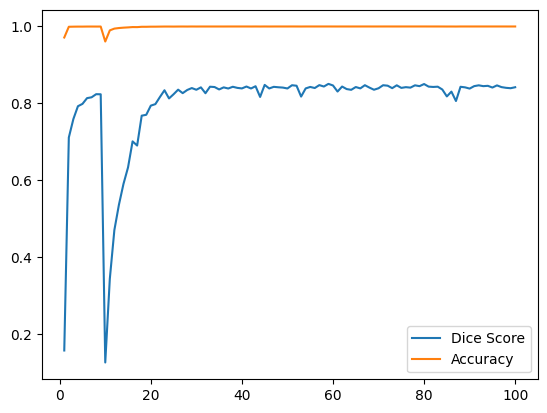

In [16]:
from matplotlib import pyplot as plt

plt.plot(range(1, NUM_EPOCHS+1), dice_score_list, label='Dice Score')
plt.plot(range(1, NUM_EPOCHS+1), accuracies, label='Accuracy')
plt.legend()

In [17]:
checkpoint = torch.load("/content/checkpoint.pth")

UNET.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

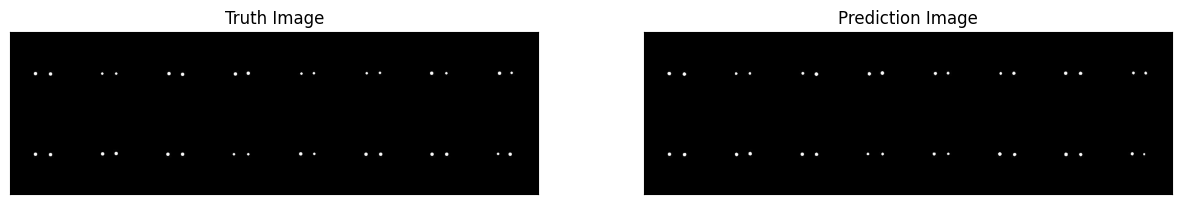

In [18]:
import matplotlib.pyplot as plt

truth_image = Image.open('/content/Saved_Images/truth_0.jpg')
pred_image = Image.open('/content/Saved_Images/pred_0.jpg')


figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(truth_image)
plt.title('Truth Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(pred_image)
plt.title('Prediction Image'), plt.xticks([]), plt.yticks([])
plt.show()